In [106]:
import numpy as np

In [107]:
def sample_metric(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    squares = []
    transformed_squares = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        square = matrix([[-sq_len/2, -sq_len/2, sq_len/2, sq_len/2], [-sq_len/2, sq_len/2, sq_len/2, -sq_len/2]])
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g(u, v) * square
        
        squares.append(square + translate)
        transformed_squares.append(transformed + translate)

    return squares, transformed_squares

In [108]:
def metric_surf_rev_numerical(phi, psi):
    def g(u, v):
        X_u = vector([-phi(v)*sin(u), phi(v)*cos(u), 0])
        X_v = vector([phi.derivative(v)*cos(u), phi.derivative(v)*sin(u), psi.derivative(v)])
        E = X_u.dot_product(X_u)
        G = X_v.dot_product(X_v)
        return matrix([[E, 0], [0, G]])
    return g

In [125]:
pi = RR.pi()

def integrate_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    theta, x, y = var('θ, x, y')
    DE0 = kappa
    DE1 = cos(theta)
    DE2 = sin(theta)
    ICs = [srange[0], theta_0, x_0, y_0]

    P = desolve_system_rk4([DE0, DE1, DE2], [theta, x, y], ics=ICs, ivar=s, end_points=srange[1], step=step)
    return P


def splines_from_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    P = integrate_curvature(kappa, s, srange, theta_0, x_0, y_0, step)

    x_spline = spline([(s, x) for s, theta, x, y in P])
    y_spline = spline([(s, y) for s, theta, x, y in P])

    return (x_spline, y_spline)


def spline_avg(f, srange):
    return f.definite_integral(srange[0], srange[1]) / (srange[1] - srange[0])


def splines_to_angular_momentum(x_0, y_0, x_1, y_1, dt, srange=(0,1)):
    def theta(a, b): return arccos(a.inner_product(b) / (a.norm() * b.norm()))
    def v_x(z): return (x_0(z) - x_1(z)) / dt
    def v_y(z): return (y_0(z) - y_1(z)) / dt
    def v(z): return vector([v_x(z), v_y(z)])
    def w(z): return v(z).norm() * sin(theta(v(z), vector([x_0(z), y_0(z)]))) / sqrt(x_0(z)^2 + y_0(z)^2) # |v| * sin(theta) / r
    integrand = lambda z: w(z) * (x_0(z)^2 + y_0(z)^2) # w * r^2
    angular_momentum = numerical_integral(integrand, srange[0], srange[1])[0] # int_S w * r^2 ds
    return angular_momentum


def splines_to_moment(x, y, srange=(0,1)):
    return numerical_integral(lambda z: (x(z)^2 + y(z)^2), srange[0], srange[1])[0]


def translate_spline(f, dy):
    return spline([(x, y + dy) for x, y in f.list()])


def rotate_splines(x, y, theta):
    x_list = x.list()
    y_list = y.list()
    
    R = matrix([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    
    completed_x_list = [(s, x, y(s)) for s, x in x_list]
    completed_y_list = [(s, x(s), y) for s, y in y_list]
    
    rotated_x_spline = spline([(s, (R*vector([x, y]))[0]) for s, x, y in completed_x_list])
    rotated_y_spline = spline([(s, (R*vector([x, y]))[1]) for s, x, y in completed_y_list])
    
    return (rotated_x_spline, rotated_y_spline)


def splines_from_curvature_fix_center(kappa, s, srange=(0,1), theta_0=0, center=(0,0), step=0.1):
    x, y = splines_from_curvature(kappa, s, srange, theta_0, 0, 0, step)
    x_bar = spline_avg(x, srange)
    y_bar = spline_avg(y, srange)
    return (translate_spline(x, -x_bar + center[0]), translate_spline(y, -y_bar + center[1]))


def flow_curvature(kappa, srange, arange, acount, theta_0=0, center=(0, 0)):
    splines = []
    rotated_splines = []
    space, dt = np.linspace(arange[0], arange[1], acount, retstep=True)
    total_counterrotation = 0
    curves = []
    for a in space:
        print(f"Calculating curve for a = {a}...")
        x, y = splines_from_curvature_fix_center(kappa(s, a), s, srange=srange, theta_0=theta_0, center=center)

        if len(splines) >= 1:
            angular_momentum = splines_to_angular_momentum(splines[-1][0], splines[-1][1], x, y, dt, srange=srange)
            I = splines_to_moment(x, y, srange=srange)
            angular_velocity = angular_momentum / I
            dtheta = angular_velocity * dt
            total_counterrotation += dtheta
            print(f"dtheta: {dtheta}")
            
        rotated_x, rotated_y = rotate_splines(x, y, total_counterrotation)
        splines.append((x, y))
        rotated_splines.append((rotated_x, rotated_y))
        
    return splines, rotated_splines

In [126]:
kappa(s, a) = 1/3 + sin(s) + 3/a * sin(3*s)
srange = (0, 6*pi)
arange = (1, 3)
acount = 10

In [127]:
_, rotated_splines = flow_curvature(kappa, srange, arange, acount, center=(6, 0))

Calculating curve for a = 1.0...
Calculating curve for a = 1.2222222222222223...
dtheta: 0.0402059976791294
Calculating curve for a = 1.4444444444444444...
dtheta: 0.029565028302292518
Calculating curve for a = 1.6666666666666665...
dtheta: 0.022146396569248362
Calculating curve for a = 1.8888888888888888...
dtheta: 0.016951956811553544
Calculating curve for a = 2.111111111111111...
dtheta: 0.013283467875962018
Calculating curve for a = 2.333333333333333...
dtheta: 0.010645400321967887
Calculating curve for a = 2.5555555555555554...
dtheta: 0.00871072639219362
Calculating curve for a = 2.7777777777777777...
dtheta: 0.0072535550066548885
Calculating curve for a = 3.0...
dtheta: 0.006128967767462828


In [128]:
print(len(rotated_splines))

10


Graphics3d Object

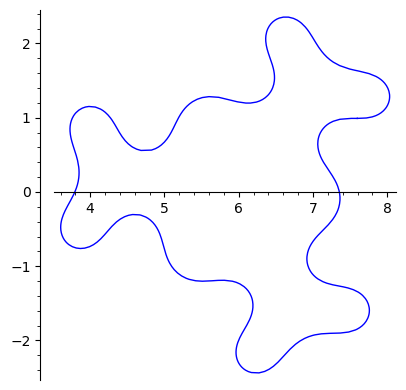

In [129]:
phi = rotated_splines[0][0]
psi = rotated_splines[0][1]

phi, psi = splines_from_curvature_fix_center(kappa(s, 1), s, srange=srange, center=(6, 0))

X = (lambda u, v: phi(v)*cos(u), lambda u, v: phi(v)*sin(u), lambda u, v: psi(v))
show(parametric_plot3d(X, (0, 2.1*pi), (0, 6*pi)))
show(parametric_plot((lambda z: phi(z), lambda z: psi(z)), (0, 6*pi)))

In [130]:
kappa(s, a) = 1/3 + sin(s) + 3/a * sin(3*s)
srange = (0, 6*pi)
arange = (1, 15)
acount = 50

phi, psi = splines_from_curvature(kappa(s, 1), s, srange, arange, acount)

phi_translate = translate_spline(phi, 10)
X = (lambda u, v: phi_translate(v)*cos(u), lambda u, v: phi_translate(v)*sin(u), lambda u, v: psi(v))
show(parametric_plot3d(X, (0, 2.1*pi), (0, 6*pi)))
show(parametric_plot((lambda z: phi_translate(z), lambda z: psi(z)), (0, 6*pi)))

AttributeError: 'tuple' object has no attribute '_maxima_'